In [136]:
import numpy as np
import matplotlib.pyplot as plt
from nacl.bindings import crypto_aead_xchacha20poly1305_ietf_decrypt
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import eigs
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [137]:
params = {
    'waveguide': {
        'core_width' : 450e-9,
        'core_height' : 220e-9,
        'n_Si': 3.48,
        'n_SiO2': 1.44,
    },
    'domain': {
        'width': 10e-6,
        'height': 6e-6,
        'dx': 5e-9,
        'dy': 5e-9,
    },
    'solver': {
        'n_modes': 5,
        'window_decay_rate': 3.0,
        'boundary_width': 0.5e-6,
    },
    'wavelength': {
        'center': 1550e-9,
        'sweep_min': 1450e-9,
        'sweep_max': 1650e-9,
        'sweep_points': 3,
    },
    'sweep': {
        'dx': 15.0e-9,
        'dy': 15.0e-9,
        'n_modes': 2,
    },
    'plot': {
        'field_cmap': 'hot',
        'xlim': (-1.0, 1.0),
        'ylim': (-0.6, 0.6),
        'cross_xlim': (-1.5, 1.5),
        'figsize': (15, 4),
        'dpi': 300,
    }
}


In [138]:
class WaveguideModeSolver:
    def __init__(self, width, height, dx, dy, wavelength, n_modes, params):
        self.width = width
        self.height = height
        self.dx = dx
        self.dy = dy
        self.wavelength = wavelength
        self.n_modes = n_modes
        self.params = params

        self.nx = int(width/self.dx)
        self.ny = int(height/self.dy)
        self.k0 = 2 * np.pi / self.wavelength

        self.epsilon_r = np.ones((self.ny, self.nx))

        self.x = np.linspace(-self.width/2, self.width/2, self.nx)
        self.y = np.linspace(-self.height/2, self.height/2, self.ny)
        self.xx, self.yy = np.meshgrid(self.x, self.y)

        self.n_eff = None
        self.Ex = None

    def add_rectangle(self, x_min, x_max, y_min, y_max, n_core, n_clad):
        i_min = int((x_min + self.width/2) / self.dx)
        i_max = int((x_max + self.width/2) / self.dx)
        j_min = int((y_min + self.height/2) / self.dy)
        j_max = int((y_max + self.height/2) / self.dy)

        i_min = max(0, i_min)
        i_max = min(self.nx, i_max)
        j_min = max(0, j_min)
        j_max = min(self.ny, j_max)

        self.epsilon_r[:, :] = n_clad ** 2
        self.epsilon_r[j_min:j_max, i_min:i_max] = n_core ** 2

    def build_matrices(self):
        nx, ny = self.nx, self.ny
        dx, dy = self.dx, self.dy

        eps = self.epsilon_r.flatten()

        main_diag_x = -2 * np.ones(nx)
        off_diag_x = np.ones(nx - 1)
        Dxx = diags([off_diag_x, main_diag_x, off_diag_x], [-1, 0, 1], shape=(nx, nx)) / dx ** 2

        main_diag_y = -2 * np.ones(ny)
        off_diag_y = np.ones(ny - 1)
        Dyy = diags([off_diag_y, main_diag_y, off_diag_y], [-1, 0, 1], shape=(ny, ny)) / dy ** 2

        Ix = eye(nx)
        Iy = eye(ny)

        laplacial = kron(Dxx, Iy) + kron(Ix, Dyy)

        k0_squared = self.k0**2
        material = diags(k0_squared * eps)

        A = laplacial + material

        B = eye(nx * ny)

        return A, B

    def solve(self):
        A, B = self.build_matrices()

        n_core = np.sqrt(np.max(self.epsilon_r))
        n_clad = np.sqrt(np.min(self.epsilon_r))

        target_n_eff = n_core - 0.03
        sigma = (target_n_eff * self.k0) ** 2

        eigenvalues, eigenvectors = eigs(A, k=self.n_modes, M=B, sigma=sigma, which='LM')

        beta = np.sqrt(eigenvalues)
        n_eff = beta / self.k0

        idx = np.argsort(-np.real(n_eff))
        n_eff = n_eff[idx]
        eigenvectors = eigenvectors[:, idx]

        valid_modes = []
        valid_n_eff = []
        valid_vectors = []

        for i, n in enumerate(n_eff):
            if np.real(n) > n_clad and np.real(n) < n_core:
                valid_modes.append(i)
                valid_n_eff.append(n)
                valid_vectors.append(eigenvectors[:, i])

        if len(valid_modes) == 0:
            valid_n_eff = n_eff[:min(2, len(n_eff))]
            valid_vectors = [eigenvectors[:, i] for i in range(min(2, len(n_eff)))]

        self.n_eff = np.array(valid_n_eff)

        nx, ny = self.nx, self.ny
        self.Ex = []

        for i, mode in enumerate(valid_vectors):
            if i >= self.n_modes:
                break
            E = mode.reshape(ny, nx)

            if i == 0:
                E_symmetric = 0.5 * (E + np.fliplr(E))
                E = E_symmetric
            elif i == 1:
                E_antisymmetric = 0.5 * (E - np.fliplr(E))
                E = E_antisymmetric

            core_width = self.params['waveguide']['core_width']
            core_height = self.params['waveguide']['core_height']
            boundary_width = self.params['solver']['boundary_width']
            decay_rate = self.params['solver']['window_decay_rate']

            dist_from_core_x = np.maximum(0, np.abs(self.xx) - core_width / 2)
            dist_from_core_y = np.maximum(0, np.abs(self.yy) - core_height / 2)
            dist_from_core = np.sqrt(dist_from_core_x ** 2 + dist_from_core_y ** 2)
            window = np.exp(-(dist_from_core / boundary_width) ** decay_rate)

            E = E * window
            E = E / np.max(np.abs(E))

            self.Ex.append(E)

        return self.n_eff

    def classify_modes(self):
        mode_types = []
        for i in range(len(self.n_eff)):
            if i % 2 == 0:
                mode_types.append('TE-like')
            else:
                mode_types.append('TM-like')

        return mode_types

    def plot_mode(self, mode_idx, n_effs_sweep=None, wavelengths_sweep=None):
        figsize = self.params['plot']['figsize']
        field_cmap = self.params['plot']['field_cmap']
        xlim = self.params['plot']['xlim']
        ylim = self.params['plot']['ylim']
        cross_xlim = self.params['plot']['cross_xlim']


        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        field = np.abs(self.Ex[mode_idx])

        # Field profile (|E|)
        im1 = ax1.imshow(field,
                         extent=[-self.width/2*1e6, self.width/2*1e6, -self.height/2*1e6, self.height/2*1e6],
                         origin='lower', cmap=field_cmap)

        divider = make_axes_locatable(ax1)
        cax1 = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im1, cax=cax1, label='|E| (normalized)')

        eps_threshold = (np.max(self.epsilon_r) + np.min(self.epsilon_r)) / 2
        ax1.contour(self.xx*1e6, self.yy*1e6, self.epsilon_r,
                    levels=[eps_threshold], colors='w', linestyles='-', linewidths=2)

        ax1.set_xlim(xlim)
        ax1.set_ylim(ylim)

        ax1.set_xlabel('x (um)')
        ax1.set_ylabel('y (um)')
        ax1.set_title(f'mode {mode_idx}, n_eff {np.real(self.n_eff[mode_idx]):.6f}')

        # Plot field cross-sections
        center_y = self.ny // 2
        center_x = self.nx // 2

        x_cross = field[center_y, :]
        y_cross = field[:, center_x]

        # Plot cross-sections

        # Add waveguide boundaries

        # Plot effective index vs wavelength if data is provided
        ax2.plot(self.x * 1e6, x_cross, label='|E(x, y=0)|')
        ax2.set_xlim(cross_xlim)
        ax2.set_xlabel('x (µm)')
        ax2.set_ylabel('|E|')
        ax2.set_title('Horizontal cross-section')
        ax2.grid(True)

        # Add waveguide boundaries in x (vertical lines)
        core_half_width = self.params['waveguide']['core_width'] * 1e6 / 2
        ax2.axvline(-core_half_width, color='gray', linestyle='--')
        ax2.axvline(core_half_width, color='gray', linestyle='--')

        ax3.plot(self.y * 1e6, y_cross, label='|E(x=0, y)|')
        ax3.set_xlabel('y (µm)')
        ax3.set_ylabel('|E|')
        ax3.set_title('Vertical cross-section')
        ax3.grid(True)

        # Add waveguide boundaries in y (horizontal lines)
        core_half_height = self.params['waveguide']['core_height'] * 1e6 / 2
        ax3.axvline(-core_half_height, color='gray', linestyle='--')
        ax3.axvline(core_half_height, color='gray', linestyle='--')

        plt.tight_layout()

        # Optional: effective index vs wavelength
        if n_effs_sweep is not None and wavelengths_sweep is not None:
            plt.figure(figsize=(6, 4))
            plt.plot(np.array(wavelengths_sweep) * 1e9, np.real(n_effs_sweep), 'o-', label=f'Mode {mode_idx}')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Effective Index')
            plt.title(f'Effective Index vs Wavelength (mode {mode_idx})')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

In [139]:
def wavelength_sweep(core_width, core_height, n_core, n_clad, wavelengths, n_modes=2, params=None):

    width = params['domain']['width']
    height = params['domain']['height']
    dx = params['sweep']['dx']
    dy = params['sweep']['dy']

    n_effs = np.full((len(wavelengths), n_modes), np.nan)

    for i, wl in enumerate(wavelengths):
        print(f"Solving for wavelength {wl * 1e9:.1f}nm")

        solver = WaveguideModeSolver(width, height, dx, dy, wl, n_modes=n_modes, params=params)

        solver.add_rectangle(-core_width / 2, core_width / 2, -core_height / 2, core_height / 2,
                             n_core, n_clad)

        n_eff = solver.solve()

        num_modes = min(len(n_eff), n_modes)
        for j in range(num_modes):
            n_effs[i, j] = np.real(n_eff[j])

    return wavelengths, n_effs

In [140]:
def main():
    # Extract parameters
    core_width = params['waveguide']['core_width']
    core_height = params['waveguide']['core_height']
    n_Si = params['waveguide']['n_Si']
    n_SiO2 = params['waveguide']['n_SiO2']

    width = params['domain']['width']
    height = params['domain']['height']
    dx = params['domain']['dx']
    dy = params['domain']['dy']

    wl_center = params['wavelength']['center']
    wl_min = params['wavelength']['sweep_min']
    wl_max = params['wavelength']['sweep_max']
    wl_points = params['wavelength']['sweep_points']

    n_modes = params['sweep']['n_modes']

    # Create wavelength sweep
    wavelengths = np.linspace(wl_min, wl_max, wl_points)

    # Perform sweep
    wl_sweep, n_effs_sweep = wavelength_sweep(core_width, core_height, n_Si, n_SiO2, wavelengths, n_modes=n_modes, params=params)

    # Solve for center wavelength for plotting modes
    solver = WaveguideModeSolver(width, height, dx, dy, wl_center, n_modes=n_modes, params=params)
    solver.add_rectangle(-core_width / 2, core_width / 2,
                         -core_height / 2, core_height / 2,
                         n_Si, n_SiO2)

    n_eff = solver.solve()
    mode_types = solver.classify_modes()

    for i, (n, mode_type) in enumerate(zip(n_eff, mode_types)):
        print(f"Mode {i}: n_eff = {n.real:.5f}, type = {mode_type}")

    # Plot the first two modes
    for i in range(min(n_modes, len(n_eff))):
        solver.plot_mode(i, n_effs_sweep[:, i], wl_sweep)
        plt.show()


Solving for wavelength 1450.0nm
Solving for wavelength 1550.0nm
Solving for wavelength 1650.0nm
Mode 0: n_eff = 1.54289, type = TE-like
Mode 1: n_eff = 1.54239, type = TM-like


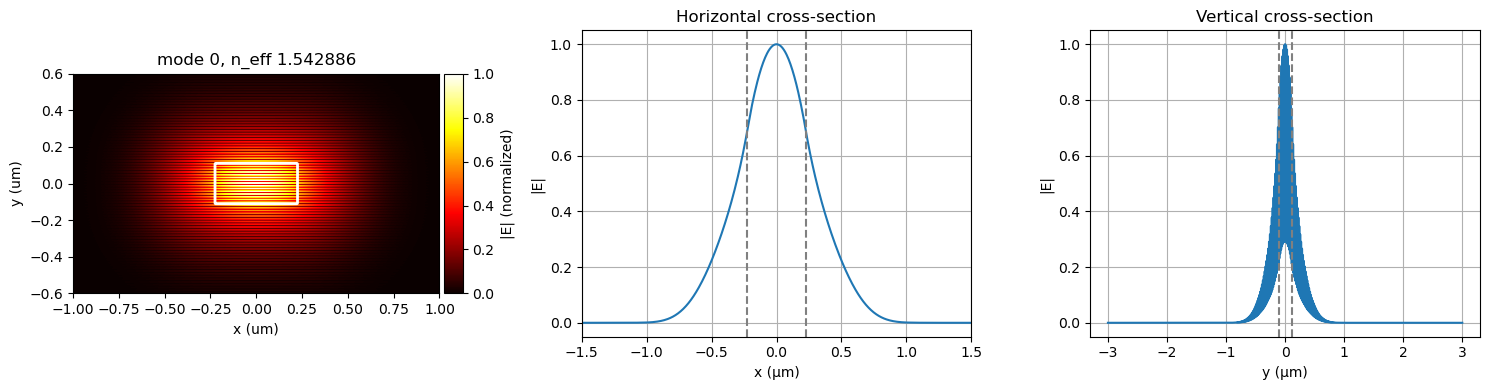

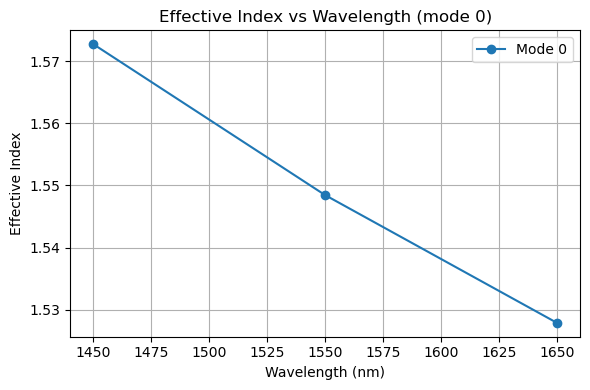

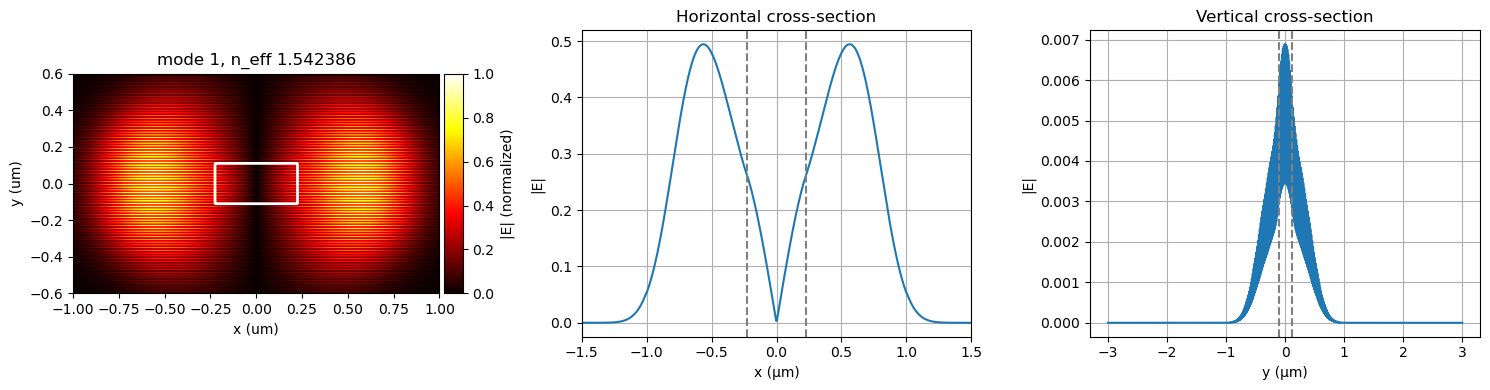

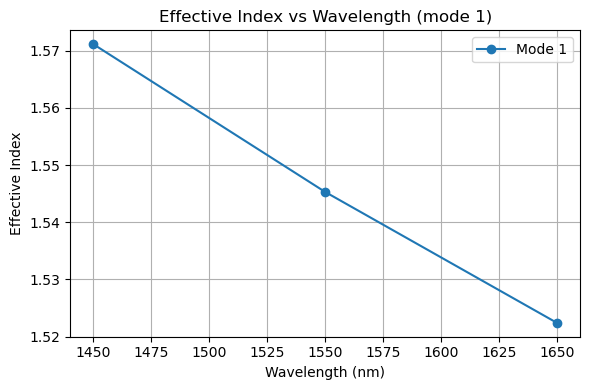

In [141]:
main()